Prediction model for Rel. substance degradation based on available analytic solutions to chemical kinetics. <br>
Linear:
\begin{align}
\frac{d[B]}{dt} =  k
\end{align}
Pseudo 0.5 order up to third order
\begin{align}
\frac{d[B]}{dt} = k [A] ^{\frac{1}{2}}, \frac{d[B]}{dt} = k [A], \frac{d[B]}{dt} = k [A] ^{\frac{3}{2}}
\end{align}

\begin{align}
\frac{d[B]}{dt} = k [A] ^{2}, \frac{d[B]}{dt} = k [A] ^{3}, 
\end{align}

Exponential model
\begin{align}
\frac{d[B]}{dt} = k \frac{[B]}{t}
\end{align}

Gustafsson-Holden model
\begin{align}
\frac{d[B]}{dt} = \frac{k_1}{k_2} [B] \left( \frac{t}{k_2} +1 \right) ^{-1}
\end{align}

Sequential models:  
First order - zero order:
\begin{align}
\frac{d[B]}{dt} = k_1 [A] - k_2
\end{align}

Zero order - first order:
\begin{align}
\frac{d[B]}{dt} = k_1  - k_2[B]
\end{align}

First order - first order:
\begin{align}
\frac{d[B]}{dt} = k_1[A]  - k_2[B]
\end{align}

In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scipy
#!pip install IPython
#!pip install ipywidgets
#!pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from IPython.display import Math, display
from scipy.stats import t
from ipywidgets import FileUpload, interact, IntSlider
import io
import csv
from matplotlib.ticker import StrMethodFormatter
import os
from sklearn.utils import resample
import ipywidgets as widgets
from IPython.display import display

In [3]:
upload = widgets.FileUpload(
    accept='.csv',
    multiple=False
)

display(upload)

FileUpload(value={}, accept='.csv', description='Upload')

In [4]:
if upload.value:
    uploaded_file = next(iter(upload.value.values()))
    
    data = pd.read_csv(io.BytesIO(uploaded_file['content']))
    
    print(data.shape)
    data.info()

    if not data.empty:
        product_name = input("Product name: ")

        headers = data.columns.tolist()
        RelSub = data.astype(float).values
    else:
        print("DataFrame is empty.")
else:
    print("No file selected.")

(15, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   monthsImp1  15 non-null     int64  
 1   Imp140C     15 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 372.0 bytes
Product name: Vori


In [5]:
#Specification limit for the related substance
spec = float(input("Specification limit: "))
print(f'Specification limit for {product_name} = {spec:.2f} %')

Specification limit: 4
Specification limit for Vori = 4.00 %


In [6]:
x_data = RelSub[:,0]
y_data = RelSub[:,1]

NameError: name 'RelSub' is not defined

In [6]:
print(x_data)
print(y_data)

[ 0.  3.  6.  9. 12. 13. 14. 15. 16.  0.  3.  6.  9. 12. 13. 14. 15. 16.
  0.  3.  6.  9. 12. 13. 14. 15. 16.  0.  3.  6.  9. 12. 13. 14. 15. 16.
  0.  3.  6.  9. 12. 13. 14. 15. 16.  0.  3.  6.  9. 12. 13. 14. 15. 16.
  0.  3.  6.  9. 12. 13. 14. 15. 16.  0.  3.  6.  9. 12. 13. 14. 15. 16.]
[0.   0.5  1.1  1.96 2.46 2.76 2.79 2.96 3.11 0.   0.5  1.09 1.98 2.36
 2.68 2.66 2.99 3.18 0.   0.51 1.08 1.95 2.36 2.73 2.8  2.87 3.03 0.1
 0.51 1.11 1.88 2.48 2.89 2.86 2.99 3.12 0.1  0.49 1.08 1.94 2.42 2.84
 2.79 3.02 3.28 0.1  0.51 1.1  1.96 2.53 2.9  2.8  3.   3.18 0.1  0.5
 1.08 1.93 2.26 2.57 2.57 2.76 2.92 0.1  0.47 1.03 1.93 2.36 2.71 2.68
 2.81 3.06]


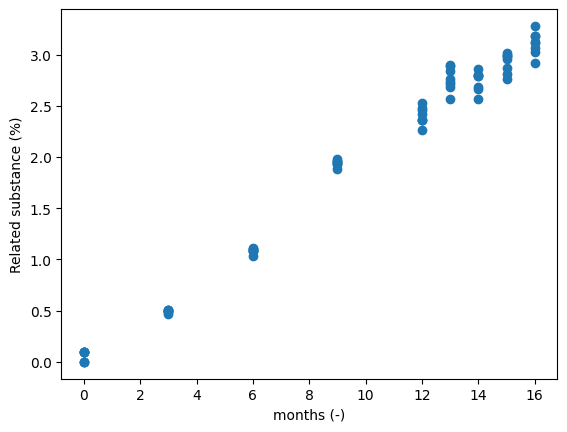

In [7]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)")
plt.ylabel("Related substance (%)")
plt.show()

Choosing the initial conditions for quations with single constant k

In [8]:
initial=[1e-10, 0.01]

Choosing initial conditions for two constant k models

In [9]:
initial_TC = [1e-10,0.0001,0.1]

All the functions as analytical solutions to the differential equations written at the beginning

In [10]:
def zero_f(t, c0, k_zero):
    return c0 + k_zero*t

def half_f(t, c0, k_half):
    return c0 + (100 - (np.sqrt(100)-(k_half*t*0.5))**2)

def first_f(t, c0, k_first):
    return c0 + 100 - 100*np.exp(-k_first*t)

def first_half_f(t, c0, k_firsth):
    return c0 + 100 - (1/((k_firsth*t*0.5)+(1/np.sqrt(100))))**2

def second_f(t, c0, k_second):
    return c0 + 100 - 1/((1/100)+(k_second*t))

def third_f(t, c0, k_third):
    return c0 + 100 - 1/(np.sqrt((1/(100**2))+(2*abs(k_third)*t)))

def exp_f(t, c0, k_exp):
    return c0 + 100 - ((100*t)**k_exp)

def guho_f(t, c0, k1_gh, k2_gh):
    return c0*(((t/k2_gh)+1)**k1_gh)

def seq_first_z_f(t, c0, k1_fz, k2_fz):
    return c0 + 100 - 100*np.exp(-k1_fz*t) - k2_fz*t

def seq_zero_f_f(t, c0, k1_zf, k2_zf):
    return k1_zf*t + c0*np.exp(-k2_zf*t)

def seq_first_f_f(t, c0, k1_ff, k2_ff):
    return c0 + ((k1_ff*100)/(k2_ff-k1_ff))*(np.exp(-k1_ff*t) - np.exp(-k2_ff*t))

def seq_pseudo_f(t, c0, k1_p, k2_p):
    return c0 + ((k1_p**k2_p)*(t*k2_p))/((scipy.special.factorial(k2_p))*np.exp(k1_p*t))

Non linear curve fitting for each model separately

In [11]:
fit_functions_2params = [zero_f, half_f, first_f, first_half_f, second_f, third_f, exp_f]
fit_functions_3params = [guho_f, seq_first_z_f, seq_zero_f_f, seq_first_f_f, seq_pseudo_f]

popts = []
pcovs = []

In [12]:
for fit_func in fit_functions_2params:
    try:
        popt, pcov = curve_fit(fit_func, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
        popts.append(popt)
        pcovs.append(pcov)
    except RuntimeError as e:
        print("There are errors for some models")
        print(f"Fit failed for {fit_func.__name__}: {e}")
        popt = np.array([np.nan, np.nan])
        pcov = np.zeros((2, 2))
        popts.append(popt)
        pcovs.append(pcov)

# Fit functions with three parameters
for fit_func in fit_functions_3params:
    try:
        popt, pcov = curve_fit(fit_func, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
        popts.append(popt)
        pcovs.append(pcov)
    except RuntimeError as e:
        print("There are errors for some models")
        print(f"Fit failed for {fit_func.__name__}: {e}")
        popt = np.array([np.nan, np.nan, np.nan])
        pcov = np.zeros((3, 3))
        popts.append(popt)
        pcovs.append(pcov)


Extraction of the different array of fitting values

In [13]:
popt_z, popt_h, popt_f, popt_fh, popt_s, popt_t, popt_exp, popt_gh, popt_fz, popt_zf, popt_ff, popt_ps = popts

In [ ]:
'''
popt_z, pcov_z = curve_fit(zero_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_h, pcov_h = curve_fit(half_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_f, pcov_f = curve_fit(first_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_fh, pcov_fh = curve_fit(first_half_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_s, pcov_s = curve_fit(second_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_t, pcov_t = curve_fit(third_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_exp, pcov_exp = curve_fit(exp_f, x_data, y_data, p0=initial, bounds=((1e-10,1e-10),(np.inf, np.inf)))
popt_gh, pcov_gh = curve_fit(guho_f, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
popt_fz, pcov_fz = curve_fit(seq_first_z_f, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
popt_zf, pcov_fz = curve_fit(seq_zero_f_f, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
popt_ff, pcov_ff = curve_fit(seq_first_f_f, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
popt_ps, pcov_ps = curve_fit(seq_pseudo_f, x_data, y_data, p0=initial_TC, bounds=((1e-10,1e-10,1e-10),(np.inf, np.inf, np.inf)))
'''

Extraction of the fitted parameters

In [14]:
#Granularity of the x_axis for the calculated X_axis data (model, confidence intervals, prediction intervals)
#number of point that will be generated by each model to form the model curve and calculate intervals
n_points = 100

In [15]:
x_model = np.linspace(min(x_data), max(x_data), num=n_points)

c0_opt_z, k_opt_z = popt_z
y_model_z = zero_f(x_model, c0_opt_z, k_opt_z)

c0_opt_h, k_opt_h = popt_h
y_model_h = half_f(x_model, c0_opt_h, k_opt_h)

c0_opt_f, k_opt_f = popt_f
y_model_f = first_f(x_model, c0_opt_f, k_opt_f)

c0_opt_fh, k_opt_fh = popt_fh
y_model_fh = first_half_f(x_model, c0_opt_fh, k_opt_fh)

c0_opt_s, k_opt_s = popt_s
y_model_s = second_f(x_model, c0_opt_s, k_opt_s)

c0_opt_t, k_opt_t = popt_t
y_model_t = third_f(x_model, c0_opt_t, k_opt_t)

c0_opt_exp, k_opt_exp = popt_exp
y_model_exp = exp_f(x_model, c0_opt_exp, k_opt_exp)

c0_opt_gh, k1_opt_gh, k2_opt_gh = popt_gh
y_model_gh = guho_f(x_model, c0_opt_gh, k1_opt_gh, k2_opt_gh)

c0_opt_fz, k1_opt_fz, k2_opt_fz = popt_fz
y_model_fz = seq_first_z_f(x_model, c0_opt_fz, k1_opt_fz, k2_opt_fz)

c0_opt_zf, k1_opt_zf, k2_opt_zf = popt_zf
y_model_zf = seq_zero_f_f(x_model, c0_opt_zf, k1_opt_zf, k2_opt_zf)

c0_opt_ff, k1_opt_ff, k2_opt_ff = popt_ff
y_model_ff = seq_first_f_f(x_model, c0_opt_ff, k1_opt_ff, k2_opt_ff)

c0_opt_ps, k1_opt_ps, k2_opt_ps = popt_ps
y_model_ps = seq_pseudo_f(x_model, c0_opt_ps, k1_opt_ps, k2_opt_ps)

print(f'Zero order parameters ({c0_opt_z:.4f}, {k_opt_z:.4f})')
print(f'Half order parameters ({c0_opt_h:.4f}, {k_opt_h:.4f})')
print(f'First order parameters ({c0_opt_f:.4f}, {k_opt_f:.4f})')
print(f'First/half order parameters ({c0_opt_fh:.4f}, {k_opt_fh:.4f})')
print(f'Second order parameters ({c0_opt_s:.4f}, {k_opt_s:.4f})')
print(f'Third order parameters ({c0_opt_t:.4f}, {k_opt_t:.4f})')
print(f'Exponential parameters ({c0_opt_exp:.4f}, {k_opt_exp:.4f})')
print(f'Gustafson Holden parameters ({c0_opt_gh:.4f}, {k1_opt_gh:.4f}, {k2_opt_gh:.4f})')
print(f'Seq. first/zero parameters ({c0_opt_fz:.4f}, {k1_opt_fz:.4f}, {k2_opt_fz:.4f})')
print(f'Seq. zero/zero parameters ({c0_opt_zf:.4f}, {k1_opt_zf:.4f}, {k2_opt_zf:.4f})')
print(f'Seq. first/first parameters ({c0_opt_ff:.4f}, {k1_opt_ff:.4f}, {k2_opt_ff:.4f})')
print(f'Pseudo exponential order parameters ({c0_opt_ps:.4f}, {k1_opt_ps:.4f}, {k2_opt_ps:.4f})')

Zero order parameters (0.0021, 0.1990)
Half order parameters (0.0000, 0.0201)
First order parameters (0.0000, 0.0020)
First/half order parameters (0.0000, 0.0002)
Second order parameters (0.0000, 0.0000)
Third order parameters (0.0000, 0.0000)
Exponential parameters (0.0000, 0.6445)
Gustafson Holden parameters (0.0037, 1.0024, 0.0187)
Seq. first/zero parameters (0.0000, 0.0034, 0.1287)
Seq. zero/zero parameters (0.0021, 0.1990, 0.0000)
Seq. first/first parameters (0.0000, 0.0021, 0.0033)
Pseudo exponential order parameters (1.1662, 0.0149, 0.2514)


In [16]:
# Interpolate the model curve to the same points as the data
y_model_interp_z = np.interp(x_data, x_model, y_model_z)
y_model_interp_h = np.interp(x_data, x_model, y_model_h)
y_model_interp_f = np.interp(x_data, x_model, y_model_f)
y_model_interp_fh = np.interp(x_data, x_model, y_model_fh)
y_model_interp_s = np.interp(x_data, x_model, y_model_s)
y_model_interp_t = np.interp(x_data, x_model, y_model_t)
y_model_interp_exp = np.interp(x_data, x_model, y_model_exp)
y_model_interp_gh = np.interp(x_data, x_model, y_model_gh)
y_model_interp_fz = np.interp(x_data, x_model, y_model_fz)
y_model_interp_zf = np.interp(x_data, x_model, y_model_zf)
y_model_interp_ff = np.interp(x_data, x_model, y_model_ff)
y_model_interp_ps = np.interp(x_data, x_model, y_model_ps)

# Calculate the residuals
residuals_z = y_data - y_model_interp_z  # residuals = observed - fitted
residuals_h = y_data - y_model_interp_h
residuals_f = y_data - y_model_interp_f
residuals_fh = y_data - y_model_interp_fh
residuals_s = y_data - y_model_interp_s
residuals_t = y_data - y_model_interp_t
residuals_exp = y_data - y_model_interp_exp
residuals_gh = y_data - y_model_interp_gh
residuals_fz = y_data - y_model_interp_fz
residuals_zf = y_data - y_model_interp_zf
residuals_ff = y_data - y_model_interp_ff
residuals_ps = y_data - y_model_interp_ps

In [17]:
model_list=["zero order","half order","first order","first half order","second order","third order",  "Exponential model", 
            "Gustafsson Holden", "Sequential first-zero order", "Sequential zero-first order", "Sequential first-first order",
           "Pseudo sequential model"]

In [18]:
#Calculate the squared residuals for model comparison and choose the opimal model as a function
SqR_z = np.sum(np.square(residuals_z))
SqR_h = np.sum(np.square(residuals_h))
SqR_f = np.sum(np.square(residuals_f))
SqR_fh = np.sum(np.square(residuals_fh))
SqR_s = np.sum(np.square(residuals_s))
SqR_t = np.sum(np.square(residuals_t))
SqR_exp = np.sum(np.square(residuals_exp))
SqR_gh = np.sum(np.square(residuals_gh))
SqR_fz = np.sum(np.square(residuals_fz))
SqR_zf = np.sum(np.square(residuals_zf))
SqR_ff = np.sum(np.square(residuals_ff))
SqR_ps = np.sum(np.square(residuals_ps))

#Create an array of all sum of square residuals
"""
SQR = [SqR_z, SqR_h, SqR_f, SqR_fh, SqR_s, SqR_t, SqR_exp, SqR_gh, SqR_fz, SqR_zf, SqR_ff, SqR_ps]
"""
SQR = [SqR_z, SqR_h, SqR_f*0.5, SqR_fh, SqR_s, SqR_t, SqR_exp, 
       SqR_gh*1.05, SqR_fz*1.05, SqR_zf*1.05, SqR_ff*1.05, SqR_ps*1.05]

#Determine the lowest Sum of square residuals
min_index = SQR.index(min(SQR))

# Remove the first smallest value from the list
SQR_wo_min = SQR[:min_index] + SQR[min_index + 1:]

# Find the index of the second smallest value and record the value
second_min_index, SQR_2nd = min(enumerate(SQR_wo_min), key=lambda x: x[1])
#SQR_2nd=SQR_wo_min[second_min_index]

#Find the index of the second smallest value in the original SQR array
min_index_2nd = SQR.index(SQR_2nd)

Creating a dictionary of models and square errors for evaluation of the best model

In [19]:
model_dict=dict(zip(model_list, SQR))
for index, (key, value) in enumerate(model_dict.items(), start=0):
    print(f'{index:<5} {key:<10} - {value:.4f}')
    
print('\n')    
print(f'First model choice, no. {min_index}, {model_list[min_index]}, {SQR[min_index]:.4f}')
print(f'Second model choice, no. {min_index_2nd}, {model_list[min_index_2nd]}, {SQR[min_index_2nd]:.4f}')

0     zero order - 1.1023
1     half order - 1.0964
2     first order - 0.5459
3     first half order - 1.0885
4     second order - 1.0865
5     third order - 1.0863
6     Exponential model - 127810.3974
7     Gustafsson Holden - 1.1573
8     Sequential first-zero order - 1.1390
9     Sequential zero-first order - 1.1574
10    Sequential first-first order - 1.1391
11    Pseudo sequential model - 34.0003


First model choice, no. 2, first order, 0.5459
Second model choice, no. 5, third order, 1.0863


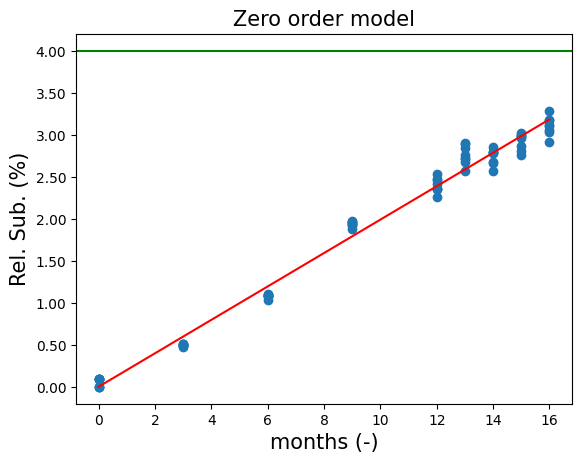

<IPython.core.display.Math object>

In [19]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_z, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Zero order model', fontsize=15)
# Set the y-axis tick labels to display values with 2 decimal places
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel. Sub]_0+kt')

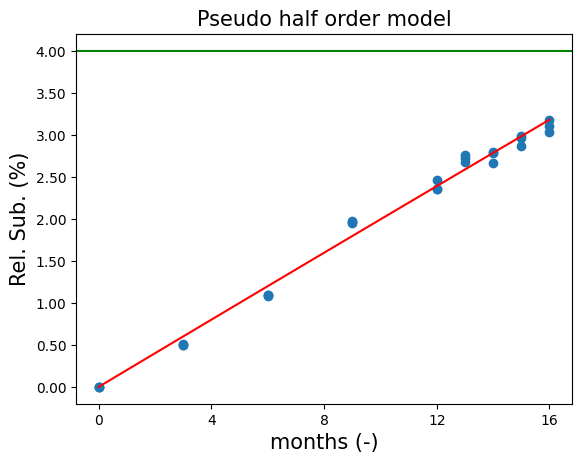

<IPython.core.display.Math object>

In [22]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_h, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Pseudo half order model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Re.Sub.]_0 + 100 - \left(\sqrt{100} - \frac{kt}{2} \right)^2')

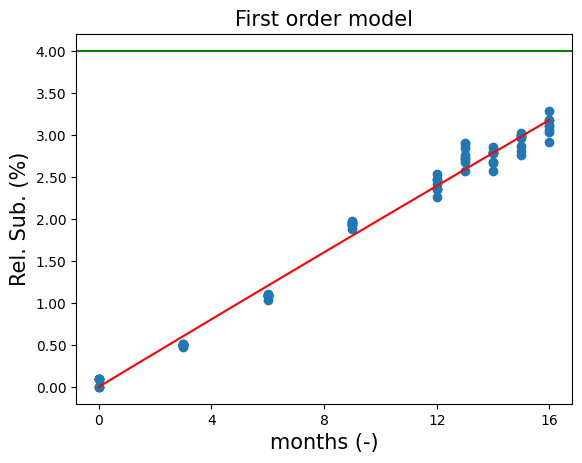

<IPython.core.display.Math object>

In [20]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_f, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('First order model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - 100 \: e^ {\large{-kt}}')

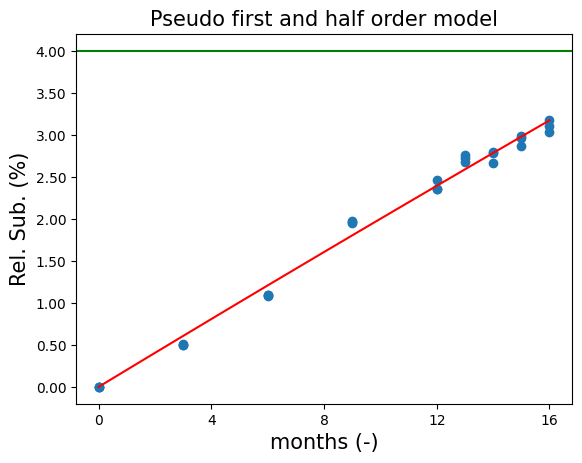

<IPython.core.display.Math object>

In [24]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_fh, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Pseudo first and half order model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \left( \frac{1}{{\large \frac{kt}{2}} + {\large \frac{1}{\sqrt{100}}}} \right)^2')

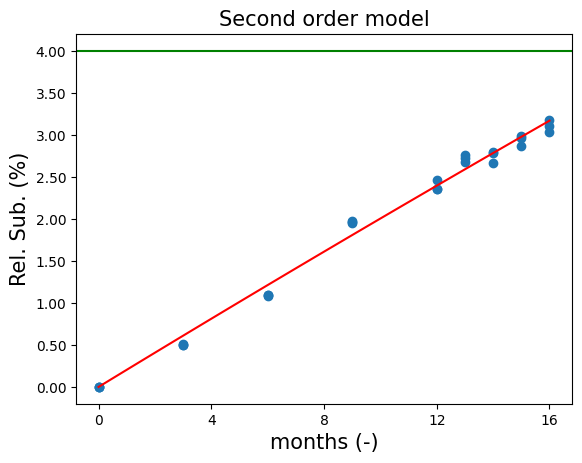

<IPython.core.display.Math object>

In [25]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_s, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Second order model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \left( \frac{1}{kt + {\large \frac{1}{100}}} \right)')

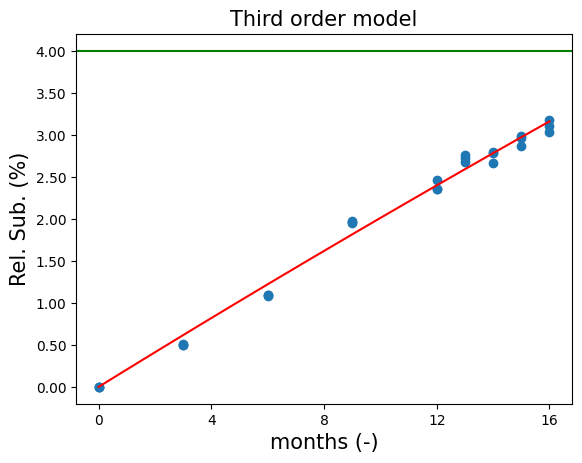

<IPython.core.display.Math object>

In [26]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_t, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Third order model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \frac{1}{\sqrt{2kt + {\large \frac{1}{100^2}}}}')

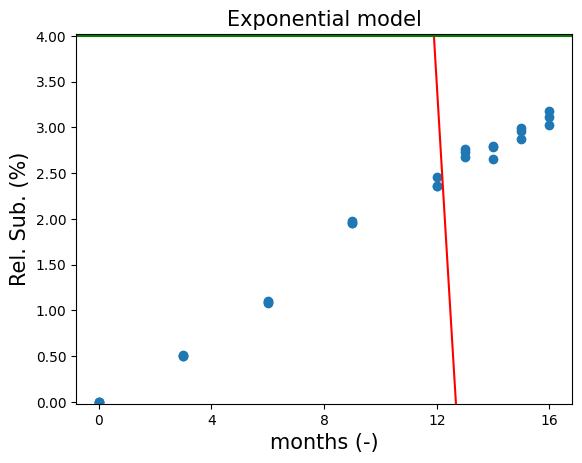

<IPython.core.display.Math object>

In [27]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_exp, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Exponential model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
# Set y-axis limits to show from 0 to spec
plt.ylim(min(y_data)-0.02, spec + 0.02)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - 100 \: t^ {k}')

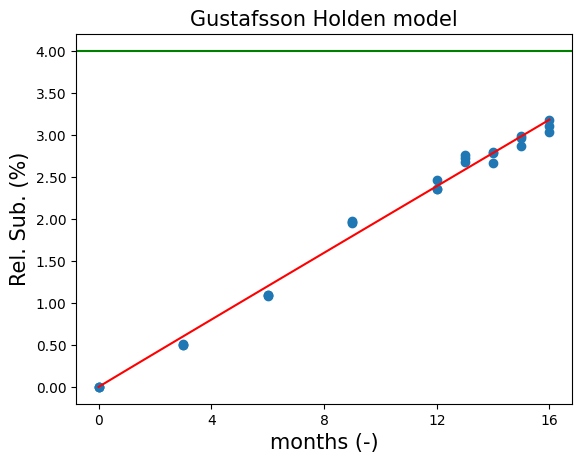

<IPython.core.display.Math object>

In [28]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_gh, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Gustafsson Holden model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 \left( \frac{t}{k_2} +1 \right) ^{k_1}')

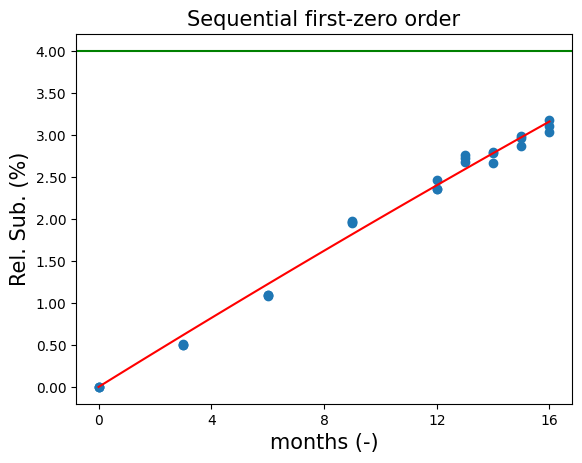

<IPython.core.display.Math object>

In [29]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_fz, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Sequential first-zero order', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 \left( 1 - e^ {\large{-k_1t}} \right) -k_2t')

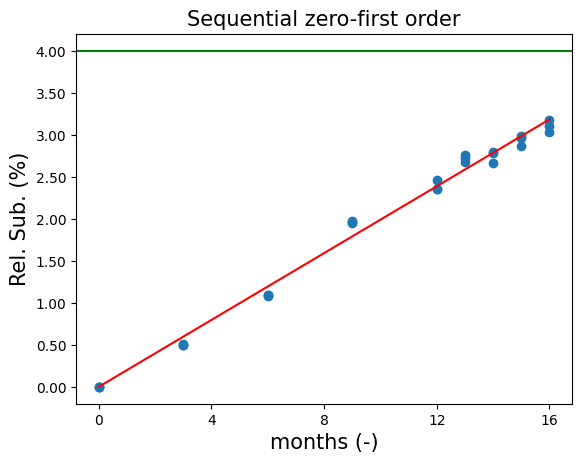

<IPython.core.display.Math object>

In [30]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_zf, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Sequential zero-first order', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = k_1t + [Rel.Sub.]_0 \:e^ {\large{-k_2t}}')

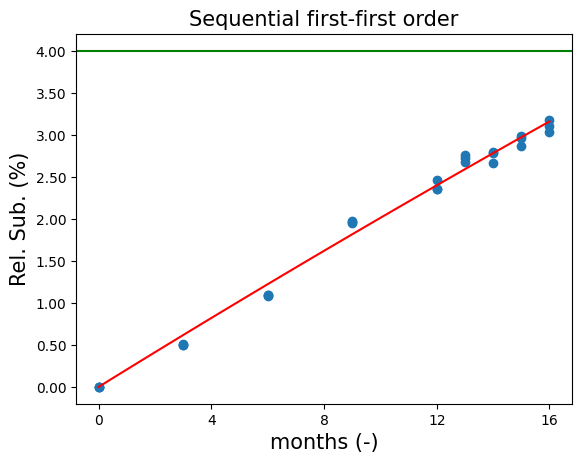

<IPython.core.display.Math object>

In [31]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_ff, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Sequential first-first order', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + \frac{100k_1}{k_2-k_1} \left( e^ {\large{-k_1t}}-e^ {\large{-k_2t}}\right)')

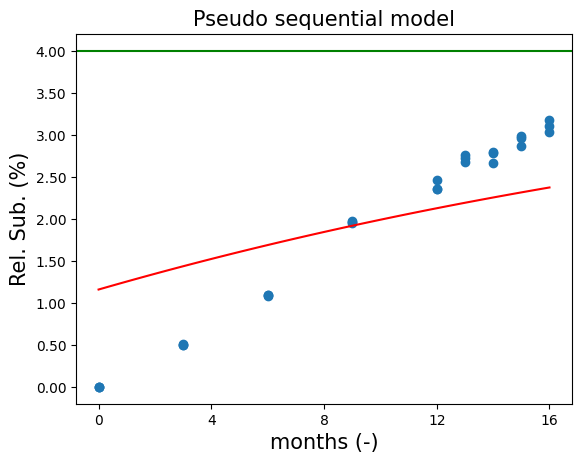

<IPython.core.display.Math object>

In [32]:
plt.scatter(x_data,y_data)
plt.xlabel("months (-)", fontsize=15)
plt.ylabel("Rel. Sub. (%)", fontsize=15)
plt.plot(x_model,y_model_ps, color='r')
plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.title('Pseudo sequential model', fontsize=15)
x_axis=np.arange(0, x_model[-1]+1,4)
plt.xticks(x_axis)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.show()

Math(r'[Rel.Sub.] = [Rel.Sub.]_0 + \frac{k_1^{k_2} \: t^{k_2}}{k_2! \: e^{\large{k_1t}}}')

In [20]:
print('The best model for the data is the **', model_list[min_index], '** model')
print('The 2nd best model for the data is the **', model_list[min_index_2nd], '** model')

#Choose the optimal function and the appropriate fitting parameters
SQR_functions = [zero_f, half_f, first_f, first_half_f, second_f, third_f, exp_f, guho_f, seq_first_z_f,
                seq_zero_f_f, seq_first_f_f, seq_pseudo_f]
optimal_model = SQR_functions[min_index]
optimal_model_2nd=SQR_functions[min_index_2nd]

fit_param = [popt_z, popt_h, popt_f, popt_fh, popt_s, popt_t, popt_exp, popt_gh, popt_zf, popt_fz, popt_ff, popt_ps]

best_fit_param = fit_param[min_index]
best_fit_param_2nd = fit_param[min_index_2nd]

y_optimal_model = optimal_model(x_model, *best_fit_param)
y_optimal_model_2nd = optimal_model_2nd(x_model, *best_fit_param_2nd)

#print(best_fit_param_2nd)
#print(y_optimal_model_2nd)

latex_strings = []
latex_strings.append(r'[Rel.Sub.] = [Rel. Sub]_0+kt')
latex_strings.append(r'[Rel.Sub.] = [Re.Sub.]_0 + 100 - \left(\sqrt{100} - \frac{kt}{2} \right)^2')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - 100 \: e^ {\large{-kt}}')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \left( \frac{1}{{\large \frac{kt}{2}} + {\large \frac{1}{\sqrt{100}}}} \right)^2')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \left( \frac{1}{kt + {\large \frac{1}{100}}} \right)')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - \frac{1}{\sqrt{2kt + {\large \frac{1}{100^2}}}}')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 - 100 \: t^ {k}')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 \left( \frac{t}{k_2} +1 \right) ^{k_1}')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + 100 \left( 1 - e^ {\large{-k_1t}} \right) -k_2t')
latex_strings.append(r'[Rel.Sub.] = k_1t + [Rel.Sub.]_0 \:e^ {\large{-k_2t}}')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + \frac{100k_1}{k_2-k_1} \left( e^ {\large{-k_1t}}-e^ {\large{-k_2t}}\right)')
latex_strings.append(r'[Rel.Sub.] = [Rel.Sub.]_0 + \frac{k_1^{k_2} \: t^{k_2}}{k_2! \: e^{\large{k_1t}}}')

The best model for the data is the ** first order ** model
The 2nd best model for the data is the ** third order ** model


Bootstrap method to calculate confidence intervals for each fitting parameter for the best model

In [21]:
from scipy.optimize import minimize

if min_index < 7:
    # Number of bootstrap iterations
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k_bs = np.zeros(n_iter)


    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(lambda p: ((optimal_model(x_resample, p[0], p[1]) - y_resample)**2).sum(), 
                       best_fit_param, bounds=bounds, method='Nelder-Mead')
        c0_bs[i], k_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean())**2)) #each bootstrap estimate - the average of boostrap estimates
    k_se = np.sqrt(np.mean((k_bs - k_bs.mean())**2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05 # Confidence level
    df = len(x_data) - len(best_fit_param) # Degree of freedom
    tval = t.ppf(1 - alpha/2, df)

    # Calculate the confidence intervals for each parameter
    c0_ci = (best_fit_param[0] - tval * c0_se, best_fit_param[0] + tval * c0_se)
    k_ci = (best_fit_param[1] - tval * k_se, best_fit_param[1] + tval * k_se)


    # Print the confidence intervals
    print("Fitting parameters for",model_list[min_index],", the best model for the data")
    print(f"c0: {best_fit_param[0]:.2f}")
    print(f"k: {best_fit_param[1]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci[0]:.2f},{c0_ci[1]:.4f})")
    print(f"Confidence intervals for k: ({k_ci[0]:.2f},{k_ci[1]:.4f})")

else:
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k1_bs = np.zeros(n_iter)
    k2_bs = np.zeros(n_iter)

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(lambda p: ((optimal_model(x_resample, p[0], p[1], p[2]) - y_resample)**2).sum(), 
                       best_fit_param, bounds=bounds, method='Nelder-Mead')
        c0_bs[i], k1_bs[i], k2_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean())**2))
    k1_se = np.sqrt(np.mean((k1_bs - k1_bs.mean())**2))
    k2_se = np.sqrt(np.mean((k2_bs - k2_bs.mean())**2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05 # Confidence level
    df = len(x_data) - len(best_fit_param) # Degree of freedom
    tval = t.ppf(1 - alpha/2, df)

    # Calculate the confidence intervals for each parameter
    c0_ci = (best_fit_param[0] - tval * c0_se, best_fit_param[0] + tval * c0_se)
    k1_ci = (best_fit_param[1] - tval * k1_se, best_fit_param[1] + tval * k1_se)
    k2_ci = (best_fit_param[2] - tval * k2_se, best_fit_param[2] + tval * k2_se)

    # Print the confidence intervals
    print("Fitting parameters for",model_list[min_index],", the best model for the data")
    print(f"c0: {best_fit_param[0]:.2f}")
    print(f"k1: {best_fit_param[1]:.4f}")
    print(f"k2: {best_fit_param[2]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci[0]:.2f},{c0_ci[1]:.4f})")
    print(f"Confidence intervals for k1: ({k1_ci[0]:.2f},{k1_ci[1]:.4f})")
    print(f"Confidence intervals for k2: ({k2_ci[0]:.2f},{k2_ci[1]:.4f})")

Fitting parameters for first order , the best model for the data
c0: 0.00
k: 0.0020
Confidence intervals for c0: (0.00,0.0000)
Confidence intervals for k: (0.00,0.0020)


Bootstrap method to calculate confidence intervals for each fitting parameter for the 2nd best model

In [22]:
from scipy.optimize import minimize

if min_index_2nd < 7:
    # Number of bootstrap iterations
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k_bs = np.zeros(n_iter)


    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(lambda p: ((optimal_model_2nd(x_resample, p[0], p[1]) - y_resample)**2).sum(), 
                       best_fit_param_2nd, bounds=bounds, method='Nelder-Mead')
        c0_bs[i], k_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean())**2)) #each bootstrap estimate - the average of boostrap estimates
    k_se = np.sqrt(np.mean((k_bs - k_bs.mean())**2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05 # Confidence level
    df = len(x_data) - len(best_fit_param_2nd) # Degree of freedom
    tval = t.ppf(1 - alpha/2, df)

    # Calculate the confidence intervals for each parameter
    c0_ci_2nd = (best_fit_param_2nd[0] - tval * c0_se, best_fit_param_2nd[0] + tval * c0_se)
    k_ci_2nd = (best_fit_param_2nd[1] - tval * k_se, best_fit_param_2nd[1] + tval * k_se)


    # Print the confidence intervals
    print("Fitting parameters for",model_list[min_index_2nd],", the second best model for the data")
    print(f"c0: {best_fit_param_2nd[0]:.2f}")
    print(f"k: {best_fit_param_2nd[1]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci_2nd[0]:.2f},{c0_ci_2nd[1]:.2f})")
    print(f"Confidence intervals for k: ({k_ci_2nd[0]:.4f},{k_ci_2nd[1]:.4f})")

else:
    n_iter = 1000

    # Store the bootstrap estimates for each parameter
    c0_bs = np.zeros(n_iter)
    k1_bs = np.zeros(n_iter)
    k2_bs = np.zeros(n_iter)

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        bounds = [(1e-10, np.inf), (1e-10, np.inf), (1e-10, np.inf)]
        res = minimize(lambda p: ((optimal_model_2nd(x_resample, p[0], p[1], p[2]) - y_resample)**2).sum(), 
                       best_fit_param_2nd, bounds=bounds,  method='Nelder-Mead')
        c0_bs[i], k1_bs[i], k2_bs[i] = res.x

    # Calculate the standard error of the bootstrap estimates
    c0_se = np.sqrt(np.mean((c0_bs - c0_bs.mean())**2))
    k1_se = np.sqrt(np.mean((k1_bs - k1_bs.mean())**2))
    k2_se = np.sqrt(np.mean((k2_bs - k2_bs.mean())**2))

    # Calculate the t-value for the given confidence level and degree of freedom
    alpha = 0.05 # Confidence level
    df = len(x_data) - len(best_fit_param_2nd) # Degree of freedom
    tval = t.ppf(1 - alpha/2, df)

    # Calculate the confidence intervals for each parameter
    c0_ci_2nd = (best_fit_param_2nd[0] - tval * c0_se, best_fit_param_2nd[0] + tval * c0_se)
    k1_ci_2nd = (best_fit_param_2nd[1] - tval * k1_se, best_fit_param_2nd[1] + tval * k1_se)
    k2_ci_2nd = (best_fit_param_2nd[2] - tval * k2_se, best_fit_param_2nd[2] + tval * k2_se)

    # Print the confidence intervals
    print("Fitting parameters for",model_list[min_index_2nd],", the second best model for the data")
    print(f"c0: {best_fit_param_2nd[0]:.2f}")
    print(f"k1: {best_fit_param_2nd[1]:.4f}")
    print(f"k2: {best_fit_param_2nd[2]:.4f}")
    print(f"Confidence intervals for c0: ({c0_ci_2nd[0]:.2f},{c0_ci_2nd[1]:.2f})")
    print(f"Confidence intervals for k1: ({k1_ci_2nd[0]:.4f},{k1_ci_2nd[1]:.4f})")
    print(f"Confidence intervals for k2: ({k2_ci_2nd[0]:.4f},{k2_ci_2nd[1]:.4f})")

Fitting parameters for third order , the second best model for the data
c0: 0.00
k: 0.0000
Confidence intervals for c0: (0.00,0.00)
Confidence intervals for k: (0.0000,0.0000)


Bootstrap method for the calculation of confidence and prediction curves for the fitted curve of the best model

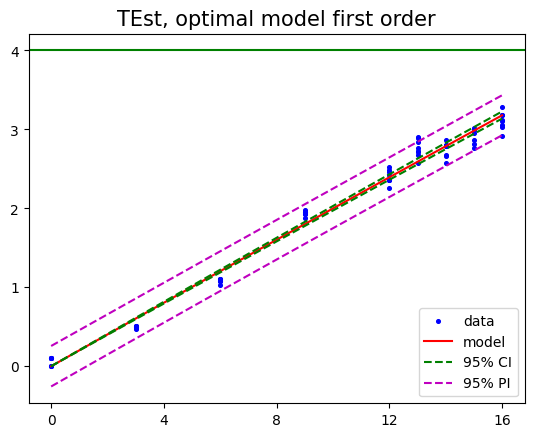

<IPython.core.display.Math object>

In [23]:
if min_index < 7:
    # Number of bootstrap iterations
    n_iter = 1000
    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs = np.zeros((n_iter, n_points))
    y_pred_bs = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        res_c = minimize(lambda p: ((optimal_model(x_resample, p[0], p[1]) - y_resample)**2).sum(), best_fit_param, method='Nelder-Mead')
        c0_bs_c, k_bs_c = res_c.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs[i, :] = optimal_model(x_model, c0_bs_c, k_bs_c)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound = np.percentile(y_model_bs, alpha/2*100, axis=0)
    upper_bound = np.percentile(y_model_bs, (1-alpha/2)*100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared = ((y_data - optimal_model(x_data, best_fit_param[0], best_fit_param[1]))**2).sum()/(len(x_data) - len(best_fit_param))
    tval = t.ppf(1 - alpha/2, len(x_data) - len(best_fit_param))

    lower_bound_p = y_model_bs.mean(axis=0) - tval *np.sqrt(sigma_squared)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())
    upper_bound_p = y_model_bs.mean(axis=0) + tval *np.sqrt(sigma_squared)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())

    # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data,y_data, label='data', marker='o', color='blue', s=7)
    plt.plot(x_model, y_optimal_model, 'r-', label='model')
    plt.plot(x_model, lower_bound, 'g--', label='95% CI')
    plt.plot(x_model, upper_bound, 'g--')
    plt.plot(x_model, lower_bound_p, 'm--', label='95% PI')
    plt.plot(x_model, upper_bound_p, 'm--')
    plt.title(f'{product_name}, optimal model {model_list[min_index]}', fontsize=15)
    plt.axhline(y = spec, color = 'g', linestyle = '-')
    x_axis=np.arange(0, x_model[-1]+1,4)
    plt.xticks(x_axis)
    plt.legend()
    plt.show()
    display(Math(latex_strings[min_index]))
    
else:
    # Number of bootstrap iterations
    n_iter = 1000
    
    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs = np.zeros((n_iter, n_points))
    y_pred_bs = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample, y_resample = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        res = minimize(lambda p: ((optimal_model(x_resample, p[0], p[1], p[2]) - y_resample)**2).sum(), best_fit_param, method='Nelder-Mead')
        c0_bs, k1_bs, k2_bs = res.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs[i, :] = optimal_model(x_model, c0_bs, k1_bs, k2_bs)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound = np.percentile(y_model_bs, alpha/2*100, axis=0)
    upper_bound = np.percentile(y_model_bs, (1-alpha/2)*100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared = ((y_data - optimal_model(x_data,best_fit_param[0], best_fit_param[1], best_fit_param[2]))**2).sum()/(len(x_data) - len(best_fit_param))
    tval = t.ppf(1 - alpha/2, len(x_data) - len(best_fit_param))

    lower_bound_p = y_model_bs.mean(axis=0) - tval *np.sqrt(sigma_squared)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())
    upper_bound_p = y_model_bs.mean(axis=0) + tval *np.sqrt(sigma_squared)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())

    # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data,y_data, label='data', marker='o', color='blue', s=7)
    plt.plot(x_model, y_optimal_model, 'r-', label='model')
    plt.plot(x_model, lower_bound, 'g--', label='95% CI')
    plt.plot(x_model, upper_bound, 'g--')
    plt.plot(x_model, lower_bound_p, 'm--', label='95% PI')
    plt.plot(x_model, upper_bound_p, 'm--')
    plt.title(f'{product_name}, optimal model {model_list[min_index]}', fontsize=15)
    plt.axhline(y = spec, color = 'g', linestyle = '-')
    x_axis=np.arange(0, x_model[-1]+1,4)
    plt.xticks(x_axis)
    plt.legend()
    plt.show()
    display(Math(latex_strings[min_index]))

Bootstrap method for the calculation of confidence and prediction curves for the fitted curve of the 2nd best model

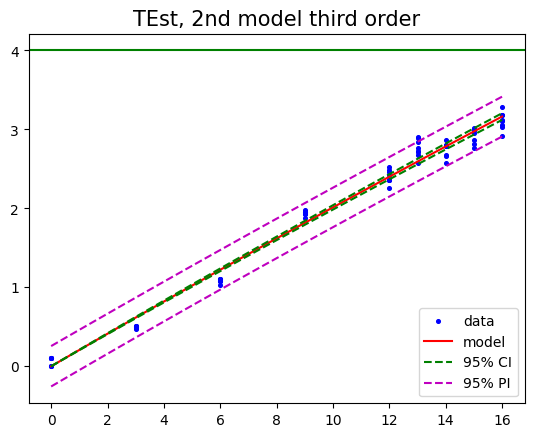

<IPython.core.display.Math object>

In [24]:
if min_index_2nd < 7:
    # Number of bootstrap iterations
    n_iter = 1000
    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs_2nd = np.zeros((n_iter, n_points))
    y_pred_bs_2nd = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample_2nd, y_resample_2nd = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        res_c_2nd = minimize(lambda p: ((optimal_model_2nd(x_resample_2nd, p[0], p[1]) - y_resample_2nd)**2).sum(),best_fit_param_2nd, method='Nelder-Mead') 
        c0_bs2_c, k_bs2_c = res_c_2nd.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs_2nd[i, :] = optimal_model_2nd(x_model, c0_bs2_c, k_bs2_c)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound_2nd = np.percentile(y_model_bs_2nd, (alpha/2)*100, axis=0)
    upper_bound_2nd = np.percentile(y_model_bs_2nd, (1-alpha/2)*100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared_2nd = ((y_data - optimal_model_2nd(x_data, best_fit_param_2nd[0], best_fit_param_2nd[1]))**2).sum()/(len(x_data) - len(best_fit_param_2nd))
    tval_2nd = t.ppf(1 - alpha/2, len(x_data) - len(best_fit_param_2nd))

    lower_bound_p_2nd = y_model_bs_2nd.mean(axis=0) - tval_2nd *np.sqrt(sigma_squared_2nd)*np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())
    upper_bound_p_2nd = y_model_bs_2nd.mean(axis=0) + tval_2nd *np.sqrt(sigma_squared_2nd)*np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())

   # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data,y_data, label='data', marker='o', color='blue', s=7)
    plt.plot(x_model, y_optimal_model_2nd, 'r-', label='model')
    plt.plot(x_model, lower_bound_2nd, 'g--', label='95% CI')
    plt.plot(x_model, upper_bound_2nd, 'g--')
    plt.plot(x_model, lower_bound_p_2nd, 'm--', label='95% PI')
    plt.plot(x_model, upper_bound_p_2nd, 'm--')
    plt.title(f'{product_name}, 2nd model {model_list[min_index_2nd]}', fontsize=15)
    plt.axhline(y = spec, color = 'g', linestyle = '-')
    plt.legend()
    plt.show()
    display(Math(latex_strings[min_index_2nd]))
    
else:
    # Number of bootstrap iterations
    n_iter = 1000
    # Store the y-values for the model curve for each bootstrap iteration for confidence and prediction intervals
    y_model_bs_2nd = np.zeros((n_iter, n_points))
    y_pred_bs_2nd = np.zeros((n_iter, n_points))

    # Perform bootstrap iterations
    for i in range(n_iter):
        # Resample the data with replacement
        x_resample_2nd, y_resample_2nd = resample(x_data, y_data, replace=True)
        # Fit the model to the resampled data
        res_2nd = minimize(lambda p: ((optimal_model_2nd(x_resample_2nd, p[0], p[1], p[2]) - y_resample_2nd)**2).sum(),best_fit_param_2nd, method='Nelder-Mead') 
        c0_bs2, k1_bs2, k2_bs2 = res_2nd.x
        # Calculate y-values for the model curve for this iteration
        y_model_bs_2nd[i, :] = optimal_model_2nd(x_model, c0_bs2, k1_bs2, k2_bs2)

    # Calculate lower and upper bounds of the confidence interval for each point on the x-axis
    alpha = 0.05
    lower_bound_2nd = np.percentile(y_model_bs_2nd, (alpha/2)*100, axis=0)
    upper_bound_2nd = np.percentile(y_model_bs_2nd, (1-alpha/2)*100, axis=0)

    # Calculate lower and upper bounds of the prediction interval for each point on the x-axis
    alpha = 0.05
    sigma_squared_2nd = ((y_data - optimal_model_2nd(x_data, best_fit_param_2nd[0], best_fit_param_2nd[1],best_fit_param_2nd[2]))**2).sum()/(len(x_data) - len(best_fit_param_2nd)) 
    tval_2nd = t.ppf(1 - alpha/2, len(x_data) - len(best_fit_param_2nd))

    lower_bound_p_2nd = y_model_bs_2nd.mean(axis=0) - tval_2nd *np.sqrt(sigma_squared_2nd)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())
    upper_bound_p_2nd = y_model_bs_2nd.mean(axis=0) + tval_2nd *np.sqrt(sigma_squared_2nd)* np.sqrt(1 + 1/len(x_data) + (x_model - x_data.mean())**2/((x_data - x_data.mean())**2).sum())
    
    # Plot the model curve and the confidence interval bounds
    plt.scatter(x_data,y_data, label='data', marker='o', color='blue', s=7)
    plt.plot(x_model, y_optimal_model_2nd, 'r-', label='model')
    plt.plot(x_model, lower_bound_2nd, 'g--', label='95% CI')
    plt.plot(x_model, upper_bound_2nd, 'g--')
    plt.plot(x_model, lower_bound_p_2nd, 'm--', label='95% PI')
    plt.plot(x_model, upper_bound_p_2nd, 'm--')
    plt.title(f'{product_name}, 2nd model {model_list[min_index_2nd]}', fontsize=15)
    plt.axhline(y = spec, color = 'g', linestyle = '-')
    x_axis=np.arange(0, x_model[-1]+1,4)
    plt.xticks(x_axis)
    plt.legend()
    plt.show()
    display(Math(latex_strings[min_index_2nd]))

In [25]:
if min_index < 7:
    print(f"[Rel.Sub.]0 = {best_fit_param[0]:.2f}")
    print(f"k = {best_fit_param[1]:.4f}")
    print(f"Confidence intervals for c0:{c0_ci[0]:.4f} to {c0_ci[1]:.4f}")
    print(f"Confidence intervals for k1:{k_ci[0]:.4f} to {k_ci[1]:.4f}")
    parameters_df = pd.DataFrame(
        {
            "Product/parameter": [product_name, " "],
            "model": [model_list[min_index], " "],
            "[Rel.Sub.]0": best_fit_param[0],
            "k": best_fit_param[1],
            "Confidence intervals for c0": c0_ci,
            "Confidence intervals for k": k_ci,
        }
    )

else:
    print(f"[Rel.Sub.]0 = {best_fit_param[0]:.2f}")
    print(f"k1 = {best_fit_param[1]:.4f}")
    print(f"k2 = {best_fit_param[2]:.4f}")
    print(f"Confidence intervals for c0: {c0_ci[0]:.2f} to {c0_ci[1]:.2f}")
    print(f"Confidence intervals for k1: {k1_ci[0]:.4f} to {k1_ci[1]:.4f}")
    print(f"Confidence intervals for k2: {k2_ci[0]:.4f} to {k2_ci[1]:.4f}")
    parameters_df = pd.DataFrame(
        {
            "Name": [product_name, " ", " "],
            "model": [model_list[min_index], " ", " "],
            "Fit param.": ["C0", "k1", "k2"],
            " ": [best_fit_param[0], best_fit_param[1], best_fit_param[2]],
            "Lower CI": [c0_ci[0], k1_ci[0], k2_ci[0]],
            "Higher CI": [c0_ci[1], k1_ci[1], k2_ci[1]],
        }
    )

# Create 'results' directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

result_df = pd.DataFrame(
    {
        "time": x_model,
        "assay": y_optimal_model,
        "95% LCI": lower_bound,
        "95% UCI": upper_bound,
        "95% LPI": lower_bound_p,
        "95% UPI": upper_bound_p,
    }
)


result_df.to_csv(os.path.join("results", f"{product_name}_1st_RelSub.csv"), index=False)
# result_df.to_excel(os.path.join('results', f'{product_name}_assay_calc.xlsx'), index=False)
display(parameters_df)

[Rel.Sub.]0 = 0.00
k = 0.0020
Confidence intervals for c0:0.0000 to 0.0000
Confidence intervals for k1:0.0020 to 0.0020


,Product/parameter,model,[Rel.Sub.]0,k,Confidence intervals for c0,Confidence intervals for k
0,TEst,first order,1.000030e-10,0.002019,9.407770e-11,0.001990
1,,,1.000030e-10,0.002019,1.059282e-10,0.002048


In [ ]:
# Concatenate the two DataFrames along the columns (axis=1)
combined_df = pd.concat([result_df, parameters_df], axis=1)
combined_df.to_excel(
    os.path.join("results", f"{product_name}_1st_RelSub.xlsx"), index=False
)

In [ ]:
excel_file_path = os.path.join("results", f"{product_name}_1st_RelSub.xlsx")

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(excel_file_path, engine="xlsxwriter")

# Position the dataframes in the worksheet.
result_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=0, header=True, index=False
)
data.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=6, header=True, index=False
)
parameters_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=8, header=True, index=False
)

# Access the XlsxWriter workbook and worksheet objects from the dataframe.
workbook = writer.book
worksheet = writer.sheets["Sheet1"]

# Create a chart object.
chart = workbook.add_chart({"type": "scatter", "subtype": "smooth"})
chart.set_title({"name": f"Rel. sub. of {product_name}"})

# Define a list of colors to cycle through
colors = ["red", "green", "green", "purple", "purple"]

# Configure the series of the chart from the dataframe data.
for i, col_name in enumerate(
    result_df.columns[1:]
):  # Start from the second column (y-axis values)
    row_start = 2  # Assuming the data starts from the second row
    row_end = len(result_df) + 1
    col_letter = chr(
        ord("B") + i
    )  # transforming the B column to integer to add i and then converting back to column letter

    chart.add_series(
        {
            "name": col_name,
            "values": f"=Sheet1!${col_letter}${row_start}:${col_letter}${row_end}",
            "categories": f"=Sheet1!$A${row_start}:$A${row_end}",
            "line": {"color": colors[i]},  # Set the color from the list
        }
    )

# Insert the chart into the worksheet.
worksheet.insert_chart("J5", chart)

writer.close()

In [29]:
if min_index_2nd < 7:
    print(f"[Rel.Sub.]0 = {best_fit_param_2nd[0]:.2f}")
    print(f"k = {best_fit_param_2nd[1]:.4f}")
    print(f"Confidence intervals for c0:{c0_ci_2nd[0]:.4f} to {c0_ci_2nd[1]:.4f}")
    print(f"Confidence intervals for k1:{k_ci_2nd[0]:.4f} to {k_ci_2nd[1]:.4f}")
    parameters2nd_df = pd.DataFrame(
        {
            "Product/parameter": [product_name, " "],
            "model": [model_list[min_index_2nd], " "],
            "[Rel.Sub.]0": best_fit_param_2nd[0],
            "k": best_fit_param_2nd[1],
            "Confidence intervals for c0": c0_ci_2nd,
            "Confidence intervals for k": k_ci_2nd,
        }
    )

else:
    print(f"[Rel.Sub.]0 = {best_fit_param_2nd[0]:.2f}")
    print(f"k1 = {best_fit_param_2nd[1]:.4f}")
    print(f"k2 = {best_fit_param_2nd[2]:.4f}")
    print(f"Confidence intervals for c0: {c0_ci_2nd[0]:.2f} to {c0_ci_2nd[1]:.2f}")
    print(f"Confidence intervals for k1: {k1_ci_2nd[0]:.4f} to {k1_ci_2nd[1]:.4f}")
    print(f"Confidence intervals for k2: {k2_ci_2nd[0]:.4f} to {k2_ci_2nd[1]:.4f}")
    parameters2nd_df = pd.DataFrame(
        {
            "Name": [product_name, " ", " "],
            "model": [model_list[min_index_2nd], " ", " "],
            "Fit param.": ["C0", "k1", "k2"],
            " ": [best_fit_param_2nd[0], best_fit_param_2nd[1], best_fit_param_2nd[2]],
            "Lower CI": [c0_ci_2nd[0], k1_ci_2nd[0], k2_ci_2nd[0]],
            "Higher CI": [c0_ci_2nd[1], k1_ci_2nd[1], k2_ci_2nd[1]],
        }
    )

# Create 'results' directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

result2nd_df = pd.DataFrame(
    {
        "time": x_model,
        "assay": y_optimal_model_2nd,
        "95% LCI": lower_bound_2nd,
        "95% UCI": upper_bound_2nd,
        "95% LPI": lower_bound_p_2nd,
        "95% UPI": upper_bound_p_2nd,
    }
)


result2nd_df.to_csv(os.path.join("results", f"{product_name}_2nd_RelSub.csv"), index=False)
# result_df.to_excel(os.path.join('results', f'{product_name}_assay_calc.xlsx'), index=False)
display(parameters2nd_df)
display(result2nd_df)

[Rel.Sub.]0 = 0.00
k = 0.0000
Confidence intervals for c0:0.0000 to 0.0000
Confidence intervals for k1:0.0000 to 0.0000


,Product/parameter,model,[Rel.Sub.]0,k,Confidence intervals for c0,Confidence intervals for k
0,TEst,third order,1.000000e-10,2.074796e-07,9.506607e-11,2.045553e-07
1,,,1.000000e-10,2.074796e-07,1.049339e-10,2.104039e-07


,time,assay,95% LCI,95% UCI,95% LPI,95% UPI
0,0.000000,1.000018e-10,9.273897e-11,1.090392e-10,-0.255878,0.255878
1,0.161616,3.351520e-02,3.304413e-02,3.398627e-02,-0.222187,0.289199
2,0.323232,6.699672e-02,6.605552e-02,6.793790e-02,-0.188532,0.322490
3,0.484848,1.004446e-01,9.903422e-02,1.018550e-01,-0.154914,0.355750
4,0.646465,1.338590e-01,1.319803e-01,1.357375e-01,-0.121333,0.388979
...,...,...,...,...,...,...
95,15.353535,3.040985e+00,3.000126e+00,3.081792e+00,2.788156,3.292243
96,15.515152,3.071536e+00,3.030286e+00,3.112733e+00,2.818590,3.322895
97,15.676768,3.102058e+00,3.060417e+00,3.143645e+00,2.848992,3.353522
98,15.838384,3.132550e+00,3.090520e+00,3.174526e+00,2.879361,3.384123


In [ ]:
# Concatenate the two DataFrames along the columns (axis=1)
combined_df = pd.concat([result2nd_df, parameters2nd_df], axis=1)
combined_df.to_excel(
    os.path.join("results", f"{product_name}_2nd_RelSub.xlsx"), index=False
)

In [ ]:
excel_file_path = os.path.join("results", f"{product_name}_2nd_RelSub.xlsx")

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(excel_file_path, engine="xlsxwriter")

# Position the dataframes in the worksheet.
result_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=0, header=True, index=False
)
data.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=6, header=True, index=False
)
parameters_df.to_excel(
    writer, sheet_name="Sheet1", startrow=0, startcol=8, header=True, index=False
)

# Access the XlsxWriter workbook and worksheet objects from the dataframe.
workbook = writer.book
worksheet = writer.sheets["Sheet1"]

# Create a chart object.
chart = workbook.add_chart({"type": "scatter", "subtype": "smooth"})
chart.set_title({"name": f"Rel. sub. of {product_name}"})

# Define a list of colors to cycle through
colors = ["red", "green", "green", "purple", "purple"]

# Configure the series of the chart from the dataframe data.
for i, col_name in enumerate(
    result_df.columns[1:]
):  # Start from the second column (y-axis values)
    row_start = 2  # Assuming the data starts from the second row
    row_end = len(result_df) + 1
    col_letter = chr(
        ord("B") + i
    )  # transforming the B column to integer to add i and then converting back to column letter

    chart.add_series(
        {
            "name": col_name,
            "values": f"=Sheet1!${col_letter}${row_start}:${col_letter}${row_end}",
            "categories": f"=Sheet1!$A${row_start}:$A${row_end}",
            "line": {"color": colors[i]},  # Set the color from the list
        }
    )

# Insert the chart into the worksheet.
worksheet.insert_chart("J5", chart)

writer.close()

Making a prediction for a longer time period for the same fitted parameters as the optimal model

In [ ]:
predic_period = int(input("Months of prediction = "))

In [ ]:
x_model_p = np.linspace(min(x_data), predic_period, num=200)
y_model_p = optimal_model(x_model_p, *best_fit_param)

x_model_p_2nd = np.linspace(min(x_data), predic_period, num=200)
y_model_p_2nd = optimal_model_2nd(x_model_p_2nd, *best_fit_param_2nd)

In [ ]:
plt.title('Prediction for best model '+ model_list[min_index], fontsize=15)
plt.scatter(x_data,y_data, label="Experimental data")
plt.xlabel("months (-)")
plt.ylabel("Rel. Sub. (%)")
plt.plot(x_model_p,y_model_p, color='orange', label="model data")

plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.xlim([0, x_model_p[-1]])
x_axis=np.arange (0,x_model_p[-1]+1,4)
y_axis=np.arange(np.round(best_fit_param[0]-0.1),spec+0.1, np.round(((spec+0.1)-(best_fit_param[0]-0.1))/10,1))
plt.xticks(x_axis)
plt.yticks(y_axis)
plt.legend()
plt.show()
display(Math(latex_strings[min_index]))

print(f"The value for the impurity at {x_model_p[-1]:.0f} months will be {y_model_p[-1]:.2f}%")
print(((spec+0.1)-(np.round(best_fit_param[0]-0.1)))/10)

In [ ]:
plt.title('Prediction for 2nd best model '+ model_list[min_index_2nd], fontsize=15)
plt.scatter(x_data,y_data, label="Experimental data")
plt.xlabel("months (-)")
plt.ylabel("Rel. Sub. (%)")
plt.plot(x_model_p_2nd,y_model_p_2nd, color='orange', label="model data")

plt.axhline(y = spec, color = 'g', linestyle = '-')
plt.xlim([0, x_model_p_2nd[-1]])
x_axis=np.arange (0,x_model_p_2nd[-1]+1,4)
y_axis=np.arange(np.round(best_fit_param_2nd[0]-0.1),spec+0.1,0.5)
plt.xticks(x_axis)
plt.yticks(y_axis)
plt.legend()
plt.show()
display(Math(latex_strings[min_index_2nd]))

print(f"The value for the impurity at {x_model_p_2nd[-1]:.0f} months will be {y_model_p_2nd[-1]:.2f}%")

In [ ]:
from scipy.optimize import fsolve

def find_intersection(func, target_y, x_range, *params):
    # Define a function that represents the difference between the model and the target y
    diff_func = lambda x: func(x, *params) - target_y
    
    # Use fsolve to find the root (intersection point)
    intersection_x = fsolve(diff_func, x_range)

    return intersection_x[0] if len(intersection_x) > 0 else None

# Find the intersection for spec limit
target_y = spec
x_range = (min(x_model_p), max(x_model_p))  # Adjust the range based on your data
intersection_x = find_intersection(optimal_model, target_y, x_range, *best_fit_param)

if intersection_x is not None:
    print(f'The time value where the optimal model intersects with {target_y}% is at {intersection_x:.2f} months')
else:
    print(f'No intersection found within the given range.')

In [ ]:
# Find the intersection for spec limit
target_y = spec
x_range_2nd = (min(x_model_p), max(x_model_p))  # Adjust the range based on your data
intersection_x_2nd = find_intersection(optimal_model_2nd, target_y, x_range_2nd, *best_fit_param_2nd)

if intersection_x_2nd is not None:
    print(f'The time value where the 2nd optimal model intersects with {target_y}% is at {intersection_x_2nd:.2f} months')
else:
    print(f'No intersection found within the given range.')